# Forecasting U.S. GDP growth

In this project, we will forecast the growth rate of U.S. GDP for the 9 quarters after December 2019. Some economists believe that the U.S. economy will enter a recession by the end of 2020:
<br>

* According to a survey conducted by the National Association for Business Economists, two-thirds of the economists surveyed believed the U.S. would enter a recession by the end of 2020. [(Source)](https://apnews.com/5df2300faa8a4f74b9b0f3ae2b6c64aa)
<br>

* In June 2018, former Federal Reserve Chairman Ben Bernanke said "\[The stimulus\] is going to hit the economy in a big way this year and next year, and then in 2020 Wile E. Coyote is going to go off the cliff." [(Source)](https://www.bloomberg.com/news/articles/2018-06-07/bernanke-says-u-s-economy-faces-wile-e-coyote-moment-in-2020)

No one thought a global pandemic was about to occur.

Here, I will develop an OLS autoregressive model with other indicators that are predictive of GDP growth to the model. 

## Part (a): Importing and preparing the data 

1. Use `pandas_datareader` and the FRED API to import the following variables into a Pandas dataframe. See the API lecture notebook to see how to do this. **Set the start date as January 1, 1980.**

    * Real GDP growth rate (quarterly): code 'A191RL1Q225SBEA'
    * Unemployment rate (monthly): code 'UNRATE'
    * Consumer price index (monthly): code 'CPIAUCSL'
    * New housing starts (monthly): code 'HOUST'
    
Use `pip` to install datareader:

```python
pip install pandas-datareader
```

Once the data are imported: 

* Give these variables more reasonable names. 
* Resample the data to the quarterly frequency using the `resample()` method for the DataFrame you created.
* Create a variable containing the inflation rate, calculated as the percentage change (i.e., `.pct_change()`)in the consumer price index. 
* Print the last 5 rows of the resulting dataframe.

In [1]:
import pandas as pd
from pandas_datareader import data          
import datetime as dt 

import numpy as np
import statsmodels.formula.api as smf


In [2]:
macro_vars = ['A191RL1Q225SBEA','UNRATE','CPIAUCSL','HOUST']

start = dt.datetime(1980, 1, 1)
fred = data.DataReader(macro_vars, 'fred', start)

fred.rename(columns={'A191RL1Q225SBEA':'gdp', 'UNRATE':'unemp', 'HOUST':'housing'}, inplace=True)
fred = fred.resample('q').mean()
fred['inflation'] = fred['CPIAUCSL'].pct_change()*100 # Inflation rate

fred.tail()

,gdp,unemp,CPIAUCSL,housing,inflation
DATE,,,,,
2021-09-30,2.7,5.100000,273.163333,1569.333333,1.638263
2021-12-31,7.0,4.233333,278.413333,1679.000000,1.921927
2022-03-31,-1.6,3.800000,284.607667,1719.666667,2.224869
2022-06-30,-0.6,3.600000,291.821667,1647.333333,2.534717
2022-09-30,NaN,3.566667,295.884000,1460.666667,1.392060


2. Use the module `yfinance` to download values for the historical S&P index (ticker: "^GSPC"). Use the same time-period as you did with the FRED data. You will have to download the package via `pip`:

```python
pip install yfinance
```

Once you have the data downloaded in DataFrame:
* Set the dates as the index. 
* Resample to the quarterly level. 
* Create a new column containing the quarterly growth rate of the S&P 500. 
* Print the last 5 rows of the resulting data frame.

In [3]:
import yfinance as yf

# Read in stock data, rename columns, format date, set date as index
end = dt.date.today()
stocks = yf.download("^GSPC", start, end)
stocks.reset_index(inplace = True)
stocks.columns = [col.lower() for col in stocks.columns]
stocks['date'] = pd.to_datetime(stocks['date'], yearfirst=True)
stocks.set_index('date', inplace = True)

# Change frequency to quarterly level:
stocks = stocks.resample('q').mean()

# Generate quarterly returns:
stocks['sp500'] = stocks['close'].pct_change()*100
stocks.tail()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj close,volume,sp500
date,,,,,,,
2021-12-31,4597.917496,4623.372498,4576.220802,4602.108894,4602.108894,3.095240e+09,4.082717
2022-03-31,4466.721467,4502.618353,4420.908558,4463.855477,4463.855477,3.990735e+09,-3.004132
2022-06-30,4113.999980,4150.028234,4065.782238,4105.667102,4105.667102,4.043743e+09,-8.024193
2022-09-30,3980.039978,4010.650932,3947.563587,3980.351112,3980.351112,3.756595e+09,-3.052269
2022-12-31,3669.823356,3718.361312,3634.081315,3678.645312,3678.645312,4.496537e+09,-7.579879


3. Now merge the two data frames created above. Keep only the columns associated with the GDP growth rate, the unemployment rate, the inflation rate, new housing starts, and the S&P 500 growth rate. Print the last 5 rows of the data frame.

In [4]:
data = pd.merge(left=fred, right=stocks, left_index=True, right_index=True, how = 'inner')

# Drop unneeded variables: 
data = data[['gdp','unemp','inflation','housing','sp500']]
data.tail()

# Save image of first five rows
dfi.export(data.head(10), 'fred.png')

## Part (b): The model and creating lagged and forward values 

Our goal is to forecast the growth rate of GDP $h$ quarters into the future, for $h=1,2,\dots,9$. Do do so we will run a separate regression for each forecast horizon, and then use the most recent values of the data (i.e., the values for the third quarter of 2018) to create the predicted value of GDP growth for each $h$.

In particular, we will use the model

$$
\begin{align}
gGDP_{t+h} = & \rho^h_0 + \rho^h_1 gGDP_t + \rho^h_2 gGDP_{t-1} + \rho^h_3 unemp_t + \rho^h_4 unemp_{t-1} \\
             & \\
             & + \rho^h_5 inflation_t + \rho^h_6 inflation_{t-1} + \rho^h_7 housing_t + \rho^h_8 housing_{t-1} \\
             & \\
             & + \rho^h_9 gSP500_t + \rho^h_{10} gSP500_{t-1} + \varepsilon_{t+h} \\
\end{align}
$$

where $gGDP_t$ is the GDP growth rate in quarter $t$, $unemp_t$ is the unemployment rate, $inflation_t$ is the inflation rate, $housing_t$ is the number of new housing starts, and $gSP500_t$ is the growth rate of the S&P 500. Note that the parameters are indexed by $h$, meaning that their values will be different for different forecast horizons.

Follow the instructions below.

1. Before estimating the model, create new columns that contain the lagged values of the explanatory variables: $gGDP_{t-1}, umep_{t-1}, inflation_{t-1}, housing_{t-1}$, and $gSP500_{t-1}$. Use the `.shift()` method.


2. We also need to create columns that contain the **forward** values of GDP growth, as these will be our dependent variables (i.e., $gGDP_{t+h}$ for $h=1,2,\dots,9$). You can either do this manually or write a loop. Name these columns 'F1gdp', 'F2gdp', etc. Again, use the `.shift()` method. Print the last 5 rows of the resulting dataframe.

In [5]:
# Create new columns containing lagged values of GDP and explanatory variables:
data['L1gdp'] = data['gdp'].shift()
data['L1unemp'] = data['unemp'].shift()
data['L1inflation'] = data['inflation'].shift()
data['L1housing'] = data['housing'].shift()
data['L1sp500'] = data['sp500'].shift()

# Create new columns to contain forward values of the GDP growth rate:
for h in range(1,10):
    var = 'F' + str(h) + 'gdp' # Create string containing the variable name, like "F1gdp"
    data[var] = data['gdp'].shift(-h) # Create column in data frame

data.tail()

,gdp,unemp,inflation,housing,sp500,L1gdp,L1unemp,L1inflation,L1housing,L1sp500,F1gdp,F2gdp,F3gdp,F4gdp,F5gdp,F6gdp,F7gdp,F8gdp,F9gdp
2021-09-30,2.7,5.100000,1.638263,1569.333333,5.687926,7.0,5.900000,1.986784,1591.333333,8.224096,7.0,-1.6,-0.6,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31,7.0,4.233333,1.921927,1679.000000,4.082717,2.7,5.100000,1.638263,1569.333333,5.687926,-1.6,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-31,-1.6,3.800000,2.224869,1719.666667,-3.004132,7.0,4.233333,1.921927,1679.000000,4.082717,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-0.6,3.600000,2.534717,1647.333333,-8.024193,-1.6,3.800000,2.224869,1719.666667,-3.004132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-30,NaN,3.566667,1.392060,1460.666667,-3.052269,-0.6,3.600000,2.534717,1647.333333,-8.024193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Part (c): Estimating the model 

Now we can estimate the model and create our forecast of GDP growth. This will require running 9 separate regressions and then obtaining the 9 predicted values. Follow the instructions below.

1. Store the values of the right hand side variables for the fourth quarter of 2019 (i.e., '2019-12-31') as a series called `current_values`.


2. Create an empty list called `forecast_list`. Then, append the value of the GDP growth rate for the fourth quarter of 2019 to this list. We will append each value of our forecast to this list as we go along - adding the current value of GDP growth just makes plotting easier.


3. Write a for-loop that iterates through each forecast horizon $(h=1,2,\dots,9)$ and estimates the model described in part (b) using OLS. The loop should do the following:
<br>

    1. Fit the model for the given time horizon. Use `stats_models`, i.e., 
    ```python
    import statsmodels.formula.api as smf
    ```

    2. Print the summary table of results **for the first regression only (i.e., for $h=1$).**
<br>

    3. Use the `.predict()` method and the series `current_values` to predict the future value of GDP for the current $h$. Then append this value to `forecast_list`.
    
Print the values of `forecast_list` to see the predicted GDP growth rates.

In [6]:
import statsmodels.formula.api as smf

Xvars = ['gdp','L1gdp', 'unemp', 'L1unemp', 'inflation', 'L1inflation', 'housing','L1housing', 'sp500', 'L1sp500']

Xvars_string = ' + '.join(Xvars)

# Series containing current values of the explanatory variables.
current_values = data.loc['2019-12-31',Xvars]

# To make plotting easier, initialize forecast_list to current value of gdp.
# This will simply connect the lines for the historical data and the forecast.
forecast_list = []
forecast_list.append(float(data.loc['2019-12-31','gdp']))

# Look at data as if it were Dec 31, 2019
data2 = data.loc[start:'2019-12-31']

# Loop through each forecast horizon:
for h in range(1,10):
    
    # Define dependant variable
    var = 'F' + str(h) + 'gdp' 
    
    # Use same trick as above to conveniently write the expression for the model:
    res = smf.ols(var + ' ~ + ' + Xvars_string, data=data2).fit()
    
    # Print results (if necessary)
    if h == 1:
        print(res.summary()) # Print results summary for first regression only
    
    # Record forecast
    pt_forecast = float(res.predict(current_values)) # The .predict() method creates the forecast of GDP.
    forecast_list.append(pt_forecast) # Append the forecast for the current horizon to the list of forecasts
    
print('')    
print(forecast_list)

                            OLS Regression Results                            
Dep. Variable:                  F1gdp   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     10.35
Date:                Sat, 22 Oct 2022   Prob (F-statistic):           4.23e-13
Time:                        10:57:20   Log-Likelihood:                -340.95
No. Observations:                 158   AIC:                             703.9
Df Residuals:                     147   BIC:                             737.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.0579      1.257     -2.433      

## Part (d): Plotting the historical data and the forecast 

1. Use the following line of code to create an object containing the values of the dates corresponding to each quarter from the fourth quarter of 2019 to the first quarter of 2022. These are the 'x' data you need for plotting the forecasts:
```python
future_dates = pd.date_range('2019-12-31', periods=10, freq='Q')
```
2. Now, create a plot of the historical GDP growth rates along with the forecasted values. **For the historical data, plot only the values since December 31, 2007 ('2007-12-31').** Make the historical data a solid black line and the forecast a blue dashed line. Shade the dates of the graph pink (i.e., color set to red with alpha equal to 0.2) for which we are making a forecast using the `.axvspan()`. Make sure the shaded forecast period also shows up in the legend by setting the `label`. Make other aspects of the plot look nice, including appropriate labels and a legend. If you want to get fancy, annotate the graph to indicate when the COVID-19 was declared a pandemic.

If you've followed these directions, your forecast should have some ups-and-downs but growth will always be positive so you would not have predicted a recession (a recession is defined as two consecutive quarters of negative growth). Your forecast will definitely not predict the pandemic's affect on U.S. GDP.

C:\Users\jt83241\AppData\Local\Temp\ipykernel_29292\4099927637.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1%}'.format(x/100) for x in ax.get_yticks().tolist()])


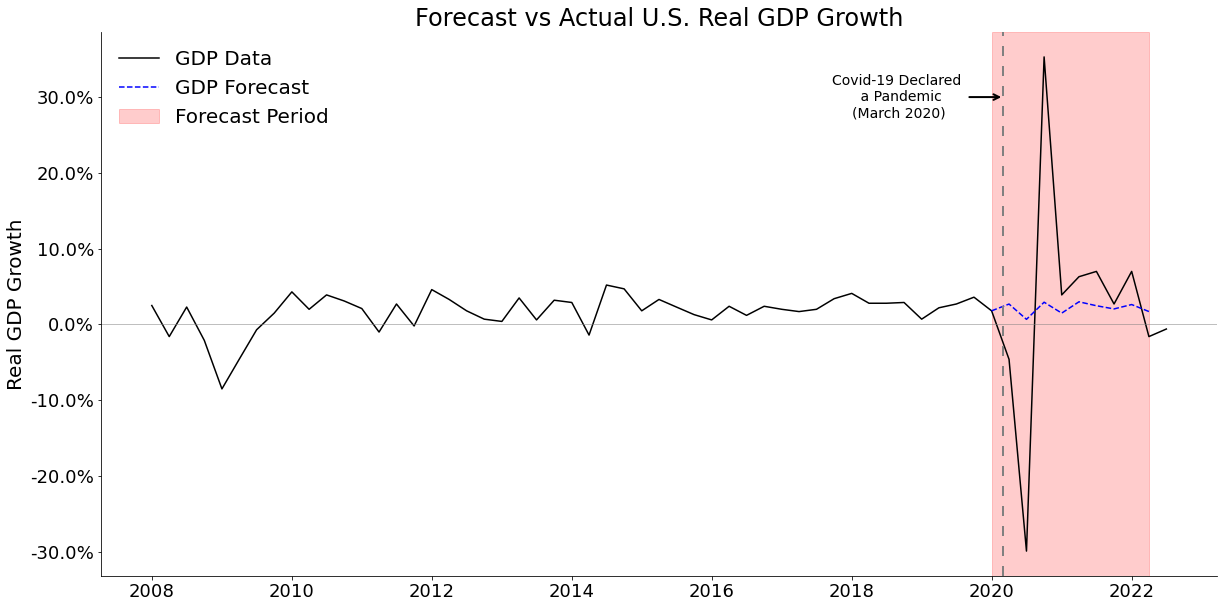

In [7]:
import matplotlib.pyplot as plt

# Create the 'x' data for the forecast p
future_dates = pd.date_range('2019-12-31', periods=10, freq='Q')

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(data.loc['2007-12-31':,'gdp'], color = 'black', label = 'GDP Data')
ax.plot(future_dates, forecast_list, color = 'blue', linestyle = '--', label = 'GDP Forecast')

# Vertical area for the forecasts
ax.axvspan(dt.datetime(2019, 12, 31), future_dates[9], alpha=0.2, color='red', label='Forecast Period')

# Horizontal line at zero
ax.axhline(y=0.0, color='grey',linewidth=0.5)

# Covid annotation
ax.axvline(x=dt.datetime(2020,3,1), ymin=0, ymax=1, color='gray', linewidth=2.0, dashes=[5,5])
ax.annotate("Covid-19 Declared \n a Pandemic\n(March 2020)", 
                   ha = 'center', va = 'center', 
                   color='black',
                   size=14,
                   xytext = (dt.datetime(2018,9,1), 30),
                   xy= (dt.datetime(2020,3,1), 30),
                    arrowprops=dict(arrowstyle= '->',
                             color='black',
                             lw=2,
                             ls='-')
               )

# Clean up the figure, label stuff
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc = 'upper left', frameon=False)

# Format y-axis to include percent.
ax.set_yticklabels(['{:.1%}'.format(x/100) for x in ax.get_yticks().tolist()])

# Adjust font size
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=20,frameon=False)

plt.ylabel('Real GDP Growth',size=20)
plt.title('Forecast vs Actual U.S. Real GDP Growth',size=24)
plt.savefig('forecast.pdf')
plt.show()